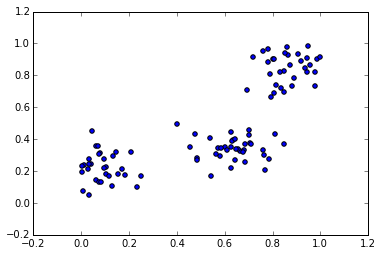

In [89]:
%matplotlib inline
import random
import math
import matplotlib.pyplot as plt
import numpy as np

sigma_o = 0.1

def rejectSampleGauss((x,y)):
    _x = x+random.gauss(0, sigma_o)
    _y = y+random.gauss(0, sigma_o)
    return (_x,_y) if 0<=_x<=1 and 0<=_y<=1 else rejectSampleGauss((x,y))

netSpeed = 1.0
nObj = 100
weights = [10.0 if random.random()>0.75 else 1.0 for o in range(nObj)]
rx, ry = 1.0, 1.0
k = 3
gc = [(random.random(), random.random()) for t in range(k)]
pAssign = [int(random.random()*k) for t in range(nObj)]
points = [(t, rejectSampleGauss(gc[pAssign[t]])) for t in range(nObj)]
plt.scatter([x for (t, (x,y)) in points], [y for (t, (x,y)) in points])
plt.show()

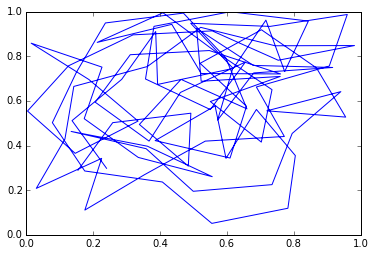

In [159]:
sl, su = 1.0/10, 3.0/10
sigma_p = 1.0

def normalize((vx, vy), speed):
    lennorm = math.sqrt(vx**2+vy**2)
    return (vx/lennorm*speed, vy/lennorm*speed)

def move((ux, uy), (vx, vy), speed):
    speeed = random.random()*(su-sl)+sl
    (_vx, _vy) = normalize((vx+random.gauss(0, sigma_p), vy+random.gauss(0, sigma_p)), speed)
    return ((ux+_vx, uy+_vy), (_vx, _vy), speed) if 0<=ux+_vx<=1 and 0<=uy+_vy<=1 else move((ux, uy), (vx, vy), speed) 

speed = random.random()*(su-sl)+sl
ux, uy = random.random(), random.random()
vx, vy = normalize((2*random.random()-1, 2*random.random()-1), speed)

timeMax = 100
movement = [((ux, uy), (vx,vy), speed)]
for t in xrange(timeMax):
    movement.append(move(*movement[-1]))
    
plt.plot([x for ((x,y), (vx,vy), speed) in movement], [y for ((x,y), (vx,vy), speed) in movement])
plt.show()

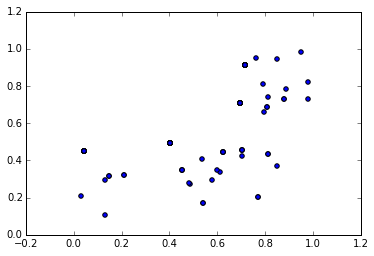

In [160]:
dropout = 0.10
objectSeen = []
for ((ux, uy), (vx, vy), speed2) in movement:
    if random.random()<dropout:
        objectSeen.append([])
    else:
        closest = min([( (x-ux)**2+(y-uy)**2,(t,(x,y)) ) 
                                for (t,(x,y)) in points])
        objectSeen.append([closest[1]])

plt.scatter([scene[0][1][0] for scene in objectSeen if len(scene)>0], [scene[0][1][1] for scene in objectSeen if len(scene)>0])
plt.show()

In [161]:
#Naive Strategy
contractSeen = map(lambda x: x[0], filter(lambda x: len(x)>0, objectSeen))
uniqueSeen = [contractSeen[0]]+[contractSeen[t+1] for t in range(len(contractSeen)-1) if contractSeen[t] != contractSeen[t+1]]
print 'Dowload Sum: ', sum(map(lambda x: weights[x[0]], uniqueSeen))
print 'Latency Exp: ', sum(map(lambda x: weights[x[0]], uniqueSeen))/netSpeed

Dowload Sum:  165.0
Latency Exp:  165.0


In [162]:
def predict((x,y), (vx, vy), speed):
    return [((x+1*vx-px)+(y+1*vy-py)**2, t) for (t, (px, py)) in points]

def decide(prob, maxSize):
    prob = sorted(prob)
    sendList = []
    sizeNow = 0
    for (_, t) in prob:
        if weights[t]+sizeNow<=maxSize:
            sendList.append(t)
            sizeNow += weights[t]
    return sendList[::-1]

In [163]:
#Predictive Strategy
maxBufferLen = 10
bufferList, objList = [], []
download, latency, hits, misses, demand = 0, 0, 0, 0, -1
maxSize = 10
for t in range(timeMax):
    ((ux, uy), (vx, vy), speed) = movement[t]
    if len(objectSeen[t])>0:
        if objectSeen[t][0][0] in bufferList:
            hits += 1
        else:
            misses += 1
            latency += weights[objectSeen[t][0][0]]
            demand = objectSeen[t][0][0]
    needToSend, needSize = [], 0
    if demand != -1:
        needToSend = [demand]
        needSize = weights[demand]
    prob = predict((ux, uy), (vx, vy), speed)
    objList = decide(prob, maxSize-needSize)
    bufferList = (bufferList+objList+needToSend)[-maxBufferLen:]
    download += sum([weights[obj] for obj in objList+needToSend])
    demand = -1
    
print "Dowload Sum: ", download
print "Latency Exp: ", latency/netSpeed
print "Accuracy   : ", hits*1.0/(hits+misses)

Dowload Sum:  1000.0
Latency Exp:  147.0
Accuracy   :  0.166666666667
